In [157]:
import datasets
data = datasets.load_dataset("/home/shadeform/data-flywheel-fsi/data/news_data_raw")
data

DatasetDict({
    train: Dataset({
        features: ['headline', 'label'],
        num_rows: 153511
    })
})

# (Optional) Use a teacher model to generate labels

Skip this section if you want to use the labels which are already pre-populate.
This notebook takes around an hour to run:
- Deploy llama 3.3 70b model 15-20 mins
- Run prompt on sample dataset (115k examples) 35-45 mins depending on GPU hardware

In [158]:
import requests
import time
import datasets
import pandas as pd

In [159]:
# Delete a model deployment (running instance)
def delete_model_deployment(ENTITY_STORE_URL,name, namespace="meta"):
    """Delete a model deployment from nemo.test (stops the running instance)"""
    url = f"{ENTITY_STORE_URL}/v1/deployment/model-deployments/{namespace}/{name}"
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    
    response = requests.delete(url, headers=headers)
    print(f"Status: {response.status_code}")
    if response.status_code == 200:
        print(f"Successfully deleted deployment {namespace}/{name}")
        return response.json()
    else:
        print(f"Error: {response.text}")
        return None

# Delete a model from Entity Store (registry)
def delete_model_from_store(ENTITY_STORE_URL,name, namespace="meta"):
    """Delete a model from Entity Store (removes from model registry)"""
    url = f"{ENTITY_STORE_URL}/v1/models/{namespace}/{name}"
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    
    response = requests.delete(url, headers=headers)
    print(f"Status: {response.status_code}")
    if response.status_code == 200:
        print(f"Successfully deleted model {namespace}/{name} from Entity Store")
        return response.json()
    else:
        print(f"Error: {response.text}")
        return None

# List all model deployments
def list_model_deployments(ENTITY_STORE_URL):
    """List all model deployments"""
    url = f"{ENTITY_STORE_URL}/v1/deployment/model-deployments"
    headers = {"accept": "application/json"}
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        deployments = response.json()
        print(f"Found {len(deployments)} deployment(s):\n")
        return deployments
    else:
        print(f"Error: {response.text}")
        return None

def create_model_deployment(ENTITY_STORE_URL,name, namespace="meta", payload=None):
    """Create a new model deployment"""
    url = f"{ENTITY_STORE_URL}/v1/deployment/model-deployments"
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    response = requests.post(url, headers=headers, json=payload)
    print(response.status_code)
    print(response.json())

In [160]:
list_model_deployments("http://nemo.test")

Found 4 deployment(s):



{'data': None,
 'filter': {},
 'object': 'list',
 'pagination': {'current_page_size': 0,
  'page': 1,
  'page_size': 10,
  'total_pages': 1,
  'total_results': 0}}

In [161]:
# create model deployment
payload = {
    "name": "llama-3.3-70b-instruct",
    "namespace": "meta",
    "config": {
        "model": "meta/llama-3.3-70b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.2-1b-instruct",
            "image_tag": "1.8.5",
            "pvc_size": "25Gi",
            "gpu": 2,
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines",
            }
        }
    }
}

create_model_deployment("http://nemo.test","llama-3.3-70b-instruct", "meta", payload)

200
{'async_enabled': False, 'config': {'model': 'meta/llama-3.3-70b-instruct', 'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'}, 'disable_lora_support': False, 'gpu': 2, 'image_name': 'nvcr.io/nim/meta/llama-3.2-1b-instruct', 'image_tag': '1.8.5', 'pvc_size': '25Gi'}}, 'created_at': '2025-10-23T20:32:13.62341578Z', 'deployed': False, 'name': 'llama-3.3-70b-instruct', 'namespace': 'meta', 'status_details': {'description': 'Model deployment created', 'status': 'pending'}, 'url': ''}


In [162]:
# List models
response = requests.get("http://nim.test/v1/models")
if response.status_code == 200:
    models = [m['id'] for m in response.json()['data']]
    print(f"Models: {models}") 

Models: []


In [ ]:
# test the deployment with a simple prompt
url = "http://nim.test/v1/chat/completions"

payload = {
    "model": "meta/llama-3.3-70b-instruct",
    "messages": [
        {"role": "user", "content": "What is the capital of France?"}
    ],
    "max_tokens": 200,
    "temperature": 0.7
}

response = requests.post(url, json=payload)
print(response.json()['choices'][0]['message']['content'])

In [ ]:
PROMPT = """
You are a helpful AI assistant that analyses financial news headlines and identifies what event type is described.
You will classify event types into one of the following categories (in square brackets)

- [Analyst Rating]: An entity such as a bank, asset manager, etc. gives a classification/rating/downgrade/upgrade/opinion to an asset.
                    If there is no specified analyst and company given, it's not Analyst Rating and should be classified as OTHER.
- [Price Targets]: A mention of a price target (PT) is given by an entity such as bank, asset manager, etc.
                   This takes priority over any other class, so if a price target is present use this class!
- [Earnings]: Reports of quarterly, monthly, etc. concrete values of revenue, ESP, etc. Percentage fluctations.
              Expected values are not Earnings and should be Guidance instead!
- [Labour Issues]: Mentions of layoffs, union action, strikes, rising cost of labour, bonuses for execs, etc. Important personal change, e.g. CEO, CFO, VPs, etc.
- [Mergers and Acquisitions]: Whenever merging or acquisition of entities, not just companies, is mentioned.
                              Things like partnerships do not belong to this class! Takes priority over other classes.
- [Dividends]: Mentions of dividend performance, dividend per share, decisions not to issue dividends, etc.
- [Regulatory]: Mentions corporate position focused on environmental affairs, government regulation, international treaties, geopolitics, debt repayment, licenses, patents, etc.
                Any executive decisions taken by the government are Regulatory. Takes priority over other classes.
- [Stock price movement]: Includes pricing of public offerings, daily, monthly and yearly movements, highs and lows, options trade and alerts, etc.
                          Only relevant when a specific entity/industry or set of entities/industries mentioned.
                          Quantities such as sales, are not stock price movements. Stock splits do not count as stock movements.
                          Takes priority over Earnings, Stock Price Movement, Credit Ratings
- [Credit Ratings]: Adjustments of company's borrowing capacity, changes in debt values, changes in ratings, etc.
- [Products-Services]: Mentions of a company's particular product, forward-looking product directions, disruption, government and private contracts, etc.
                       Any sort of delay regarding a product roll-out, etc.
- [Product Approval]: Mentions FDA approvals, environmental approvals, acceptance for review. Any time an entity approves the rollout of a corporations product.
- [Guidance]: Forward looking statements issued by the company's themselves regarding Revenue, EPS, potential sales going up/down, number of contracts, etc.
              Similar talk to earnings but about projections rather than realised.
              
If the headline doesn't match any of the classes, classify it as OTHER.
ATTENTION:
  - Only assign a category if the headline meets all the criteria listed for that category. Otherwise use OTHER
  - Encourage precise matching rather than assigning categories based on partial or superficial similarities
  - OTHER is the default category when in doubt
  - If there are no specific companies mentioned, use OTHER

A few examples:

1. Cornerstone OnDemand Higher as Barclays Upgraded to Overweight -> [Analyst Rating]
2. HC Wainwright & Co. Maintains Buy on Balchem, Lowers Price Target to $104 -> [Price Targets]
3. Sina Reports Q4 Adj. EPS $0.24 vs $0.18 Est., Sales $211.1M vs $207.6M Est.; Sees FY15 Sales $800M-$900M vs $884.6M Est. -> [Earnings]
4. Delta To Buy Out Employees, Offer Early Retirement (DAL) -> [Labour Issues]
5. Constant Contact Announces Deal to Be Purchased by Endurance Int'l at $32/Share -> [Mergers and Acquisitions]
6. Ameriprise Financial Announces 12% Qtr. Dividend Increase to $0.58/Share -> [Dividends]
7. Ultratech Achieves ISO 9001 and 14001 Certification for Singapore Operations and Recertification for U.S. Facility  -> [Regulatory]
8. Mid-Afternoon Market Update: Dow Up Over 200 Points; Lakeland Industries Shares Spike Higher -> [Stock price movement]
9. Moody's Affirms Ratings on Nokia; Outlook Revised from Negative to Developing -> [Credit Ratings]
10. NOVAVAX Awarded HHS-BARDA Contract Valued at up to $179 Million  -> [Products-Services]
11. Sanofi's Genzyme Announces Lemtrada Resubmission Accepted for Review by FDA  -> [Product Approval]
12. Dot Hill Systems Announces Re-alignment of Software Development Initiatives; Sees Q4 EPS of $(0.02)-(0.03) vs $0.03-(0.03) Prior  -> [Guidance]
13. Kopin Chairman Fan Buys 116,400 Shares @$2.83/Share -Form 4 -> [OTHER]

Given the following headline:

### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Answer only with your predicted class and give it inside double square brackets, like [[class]]
"""

In [ ]:
import asyncio
import aiohttp

async def classify_headline(session, headline):
    """Get classification for a single headline."""
    # Use the PROMPT from the notebook, formatted with the headline
    prompt = PROMPT.format(headline=headline)
    payload = {
        "model": "meta/llama-3.3-70b-instruct",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 100,
        "temperature": 0.4
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content']

async def process_dataset(dataset, num_samples=None, concurrent=10):
    """Process headlines and return DataFrame with headline and predicted_label."""
    # Access headlines directly from the dataset column
    if num_samples is None:
        headlines = dataset['train']['headline']
    else:
        headlines = dataset['train']['headline'][:num_samples]
    
    semaphore = asyncio.Semaphore(concurrent)
    
    async def classify_with_limit(session, headline):
        async with semaphore:
            label = await classify_headline(session, headline)
            return {"headline": headline, "predicted_label": label}
    
    async with aiohttp.ClientSession() as session:
        tasks = [classify_with_limit(session, h) for h in headlines]
        results = await asyncio.gather(*tasks)
    
    return pd.DataFrame(results)


In [ ]:
# For this setup we will use 50000 samples
df = await process_dataset(data, concurrent=200)
df['predicted_label'] = df['predicted_label'].apply(lambda x: x.strip('[]'))
df

,headline,predicted_label
0,24/7 Wall St. CEOs Who Need to be Fired: Nine...,Analyst Rating
1,"3 ETFs Being Driven By Russia, Time Warner An...",Mergers and Acquisitions
2,Humana and Allscripts Form Alliance to Advan...,Mergers and Acquisitions
3,2011 Investor Day: UBS Updates its Strategy a...,Earnings
4,Avanir Pharmaceuticals Reports Publication of...,Earnings
...,...,...
153506,﻿Shares of several software companies are trad...,Stock Price Movement
153507,﻿Shares of several shipping and logistics comp...,Mergers and Acquisitions
153508,﻿Shares of several vaccine companies are tradi...,Stock Price Movement
153509,﻿VBI Vaccines shares are trading higher on con...,Stock Price Movement


In [ ]:
df.groupby('predicted_label').size()

predicted_label
Acquisition                                                   16
Acquisitions                                                  16
Acquisitions and Mergers                                       2
Analyst Concerned About Harley's International Business        1
Analyst Rating                                             37150
                                                           ...  
Stock price movement                                          53
Stocks To Watch For April 8                                    1
Strategic Relationship                                         1
Supply Glut                                                    1
Trade Deficit                                                  1
Length: 63, dtype: int64

In [ ]:
VALID_LABELS = [
    "Analyst Rating",
    "Price Targets",
    "Earnings",
    "Labour Issues",
    "Mergers and Acquisitions",
    "Dividends",
    "Regulatory",
    "Stock price movement",
    "Credit Ratings",
    "Products-Services",
    "Product Approval",
    "Guidance",
    "OTHER"
]

CLEANUP_PROMPT = """You are a strict label standardization assistant. Map the predicted label to ONE of the 13 valid labels below.

VALID LABELS (use EXACTLY these names):
1. Analyst Rating
2. Price Targets
3. Earnings
4. Labour Issues
5. Mergers and Acquisitions
6. Dividends
7. Regulatory
8. Stock price movement
9. Credit Ratings
10. Products-Services
11. Product Approval
12. Guidance
13. OTHER

INSTRUCTIONS:
- Remove any prefixes like "Event Type:", brackets [[]], or extra text
- If the predicted label is a full headline or unrelated text (like "Market Wrap", "Financials", etc.), return "OTHER"
- Map common variations: "Labor Issues" → "Labour Issues", "M&A" → "Mergers and Acquisitions", etc.
- If unsure or doesn't clearly match any category → "OTHER"
- Return ONLY the exact label name from the list, nothing else

PREDICTED LABEL: {predicted_label}

YOUR ANSWER (one label only):
"""
async def clean_prediction_llm(session, prediction):
    """Use LLM to map prediction to valid label."""
    prompt = CLEANUP_PROMPT.format(predicted_label=prediction)
    payload = {
        "model": "meta/llama-3.3-70b-instruct",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 50,
        "temperature": 0.9
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content'].strip()

async def clean_dataframe_labels(df, label_column='predicted_label', concurrent=20):
    """Clean all predictions in dataframe using LLM - only process invalid labels."""
    predictions = df[label_column].unique().tolist()
    
    # Separate valid and invalid predictions
    valid_predictions = [p for p in predictions if p in VALID_LABELS]
    invalid_predictions = [p for p in predictions if p not in VALID_LABELS]
    
    print(f"Found {len(valid_predictions)} valid labels (will keep as-is)")
    print(f"Found {len(invalid_predictions)} invalid labels (will clean with LLM)\n")
    
    # Create mapping - valid ones map to themselves
    mapping = {p: p for p in valid_predictions}
    
    # Only process invalid predictions with LLM
    if invalid_predictions:
        semaphore = asyncio.Semaphore(concurrent)
        
        async def clean_with_limit(session, prediction):
            async with semaphore:
                cleaned = await clean_prediction_llm(session, prediction)
                return prediction, cleaned
        
        async with aiohttp.ClientSession() as session:
            tasks = [clean_with_limit(session, p) for p in invalid_predictions]
            results = await asyncio.gather(*tasks)
        
        # Add invalid predictions mapping
        mapping.update(dict(results))
    
    # Final safety check: map any remaining invalid labels to OTHER
    for key, value in mapping.items():
        if value not in VALID_LABELS:
            print(f"Warning: '{value}' not valid, mapping to OTHER")
            mapping[key] = "OTHER"
    
    # Apply mapping to dataframe
    df_clean = df.copy()
    df_clean[label_column] = df_clean[label_column].map(mapping)
    
    print(f"\n✓ Cleaning complete!")
    print(f"\nLabel distribution:")
    print(df_clean[label_column].value_counts())
    
    return df_clean


In [ ]:
# Clean the predictions using LLM
df_clean = await clean_dataframe_labels(df)

Found 12 valid labels (will keep as-is)
Found 51 invalid labels (will clean with LLM)

 
1. Analyst Rating → Analyst Rating
2. Price Targets → Price Targets
3. Earnings → Earnings
4. Labour Issues → Labour Issues
5. Mergers and Acquisitions → M' not valid, mapping to OTHER
13
OTHER' not valid, mapping to OTHER
2. Price Targets
3. Other
4. Labour Issues
5. Other
6. Dividends
7. Regulatory
8. Earnings
9. Products-Services
10. Guidance
11.' not valid, mapping to OTHER
2. Price Targets
4. Stock price movement
5. Mergers and Acquisitions
6. Earnings
7. Regulatory
10. Products-Services
8. Guidance' not valid, mapping to OTHER
13
OTHER' not valid, mapping to OTHER
VALID LABELS:
1. Analyst Rating
2. Price Targets
3. Earnings
4. Labour Issues
5. Mergers and Acquisitions
6. Dividends
7. Regulatory
8.' not valid, mapping to OTHER
2. Price Targets
7. Regulatory
3. Earnings
2. Mergers and Acquisitions' not valid, mapping to OTHER
2. Price Targets
3. Mergers and Acquisitions
4. Price Targets
5. Earn

In [ ]:
data['train']['label']

Column(['[[other]]', '[[stock price movement]]', '[[products-services]]', '[[guidance]]', '[[products-services]]'])

In [ ]:
# First, list all deployments to see what exists
list_model_deployments("http://nemo.test")


Found 4 deployment(s):



{'data': [{'async_enabled': False,
   'config': {'model': 'meta/llama-3.3-70b-instruct',
    'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'},
     'disable_lora_support': False,
     'gpu': 2,
     'image_name': 'nvcr.io/nim/meta/llama-3.2-1b-instruct',
     'image_tag': '1.8.5',
     'pvc_size': '25Gi'}},
   'created_at': '2025-10-23T18:59:37.18374885Z',
   'deployed': True,
   'name': 'llama-3.3-70b-instruct',
   'namespace': 'meta',
   'status_details': {'description': 'deployment "modeldeployment-meta-llama-3-3-70b-instruct" successfully rolled out\n',
    'status': 'ready'},
   'url': ''}],
 'filter': {},
 'object': 'list',
 'pagination': {'current_page_size': 1,
  'page': 1,
  'page_size': 10,
  'total_pages': 1,
  'total_results': 1}}

In [ ]:
# Save the cleaned dataset
df_clean.to_csv('classified_headlines_clean.csv', index=False)


In [ ]:
delete_model_deployment("http://nemo.test","llama-3.3-70b-instruct", "meta")

Status: 200
Successfully deleted deployment meta/llama-3.3-70b-instruct


{'deleted_at': '2025-10-23 20:24:37.084181481 +0000 UTC m=+12142.638695254',
 'id': 'llama-3.3-70b-instruct',
 'message': 'Resource deleted successfully'}

In [ ]:
delete_model_from_store("http://nemo.test","llama-3.3-70b-instruct", "meta")

Status: 200
Successfully deleted model meta/llama-3.3-70b-instruct from Entity Store


{'message': 'Resource deleted successfully.',
 'id': 'model-VwdSSvWc1jfH2b7mg5bvaJ',
 'deleted_at': None}

# Plot distribution of dataset

In [151]:

label_tracker = {}
for i in data['train']['label']:
    if i not in label_tracker:
        label_tracker[i] = 0
    label_tracker[i] += 1
df_labels = pd.DataFrame(list(label_tracker.items()), columns=['label', 'count'])

In [153]:
df_labels['label'] = df_labels['label'].str.replace(r'\[\[|\]\]', '', regex=True)
df_labels = df_labels.sort_values(by='count', ascending=False)

<Axes: ylabel='label'>

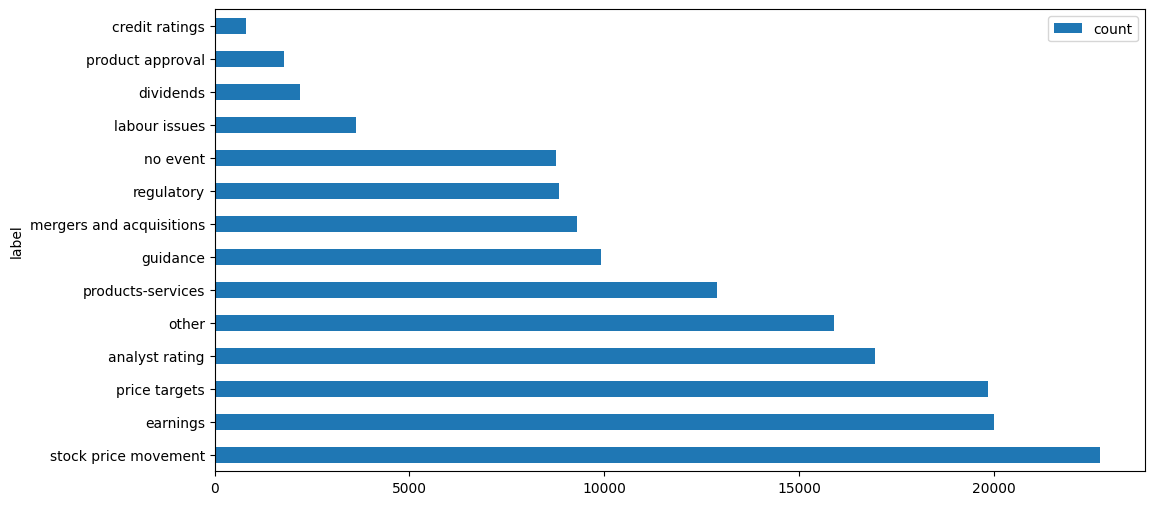

In [156]:
df_labels.plot(kind='barh', x='label', y='count', figsize=(12, 6))